# Stitching Photos with OpenCV

I took a bunch of images of a thing and I want to see if I can stitch them together into a single mosaic of the thing

In [1]:
import cv2
from anutils import data_path
from anutils.cv import rect, transform, joining
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from itertools import combinations
from math import comb

# Configuration
fa, fb = figscale = (7, 2)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = (4 * fa // fb, 3 * fa // fb)
plt.rcParams['figure.subplot.wspace'] = 0.02
plt.rcParams['figure.subplot.hspace'] = 0.02
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.aspect'] = 'auto'
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False
np.set_printoptions(precision=2)

def disp_img(image, ax=None):
    """
    Fix the color encoding for the image before displaying it
    Since opencv uses a different color map compared to matplotlib \\-.-/
    """
    rgbim = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if ax:
        ax.imshow(rgbim)
    else:
        plt.imshow(rgbim)
        plt.show()

def disp_kps(image, keypoints):
    d_img = image.copy()
    cv2.drawKeypoints(d_img, keypoints, d_img)
    disp_img(d_img)
    del d_img

def disp_mtc(img1, kps1, img0, kps0, matches01):
    d_img = cv2.drawMatches(img1, kps1, img0, kps0, 
                            matches01, None, 
                            flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
    disp_img(d_img)
    del d_img

List out all of the images

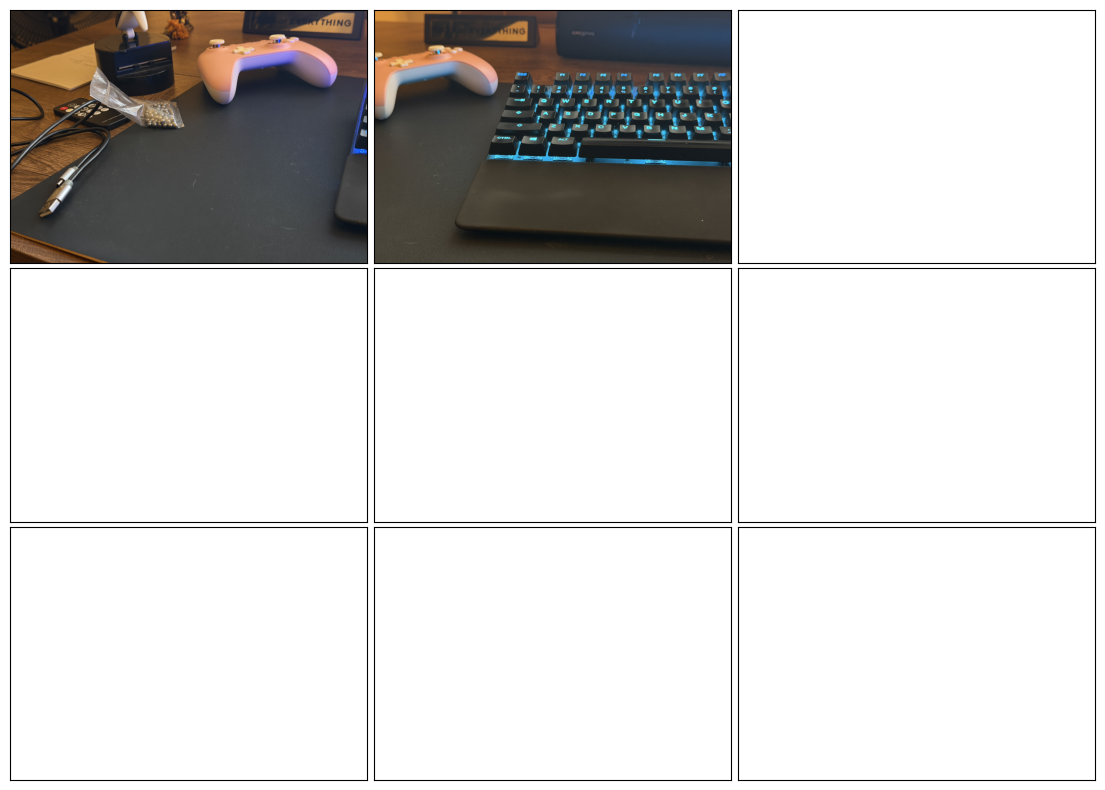

In [2]:
files_dir = data_path / 'stitching-photos'
images = [ cv2.imread(file) for file in files_dir.glob('*.JPG') ]
n_images = len(images)
fig, axs = plt.subplots(3,3)
for img, ax in zip(images, axs.flatten()):
    disp_img(img, ax)
plt.show()

Now for each image we find keypoints using SIFT and match them between each frame

Detecting keypoints:   0%|          | 0/2 [00:00<?, ?it/s]

Finding matches:   0%|          | 0/1 [00:00<?, ?it/s]

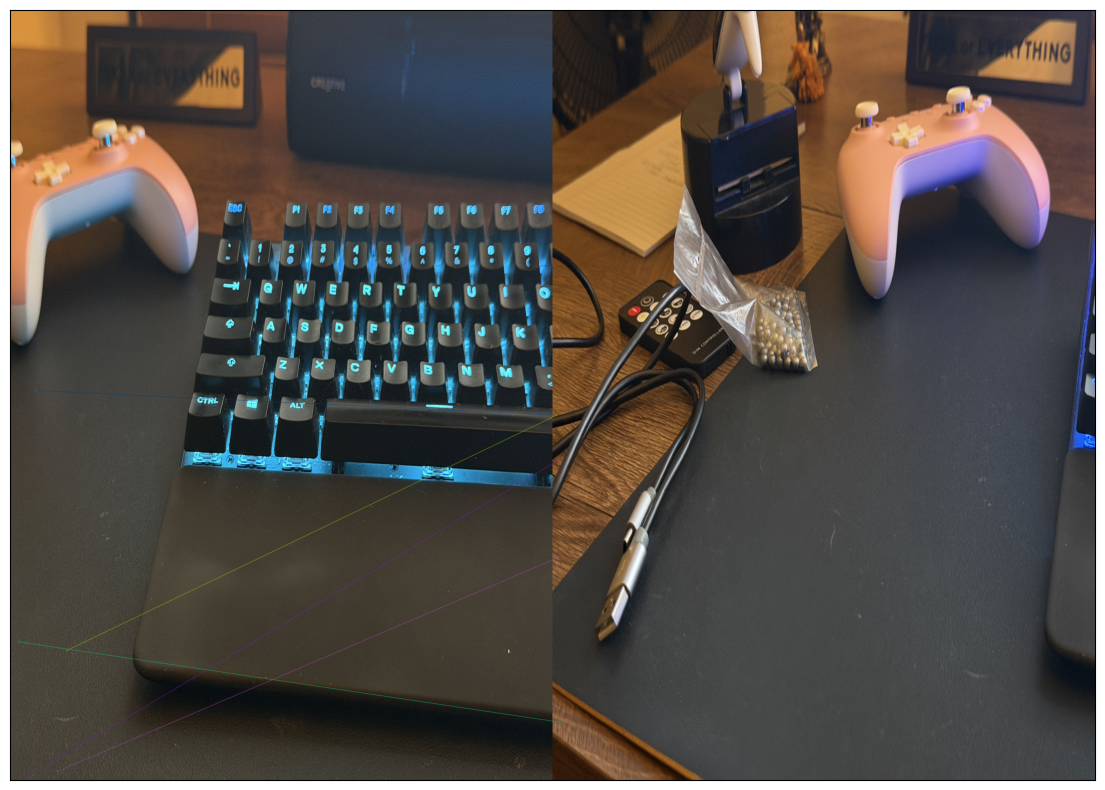

In [10]:
sift = cv2.SIFT.create()
matcher = cv2.BFMatcher()
def match_with_ratio_test(trg_dsc, src_dsc, ratio_threshold=0.5):
    match_groups = matcher.knnMatch(trg_dsc, src_dsc, k=2)
    positive_b = [ m for m in match_groups if m[0].distance > 0 ]
    return [ a for a,b in positive_b if a.distance/b.distance < ratio_threshold ]

kps = [None for _ in images]
dscs = [None for _ in images]
mtcs = [[None for _ in images] for _ in images]

for idx,img in tqdm(enumerate(images), desc="Detecting keypoints", total=n_images):
    kp, dsc = sift.detectAndCompute(img, None)
    kps[idx] = kp
    dscs[idx] = dsc

for i,j in tqdm(combinations(range(n_images), 2), desc="Finding matches", total=comb(n_images, 2)):
    mtcs[i][j] = mtcs[j][i] = match_with_ratio_test(dsc[j], dsc[i])

idx_a, idx_b = np.random.randint(n_images, size=2)
while idx_b == idx_a:
    idx_b = np.random.randint(n_images)
img_a, img_b = images[idx_a], images[idx_b]
kps_a, kps_b = kps[idx_a], kps[idx_b]
mtcs_ab = mtcs[idx_a][idx_b]

disp_mtc(img_b, kps_b, img_a, kps_a, mtcs_ab)

Using OpenCV's stitcher

In [5]:
# Create stitcher
stitcher = cv2.Stitcher.create(cv2.Stitcher_PANORAMA)
print('Stitch using %d images' % len(images))
status, pano = stitcher.stitch(images)

if status != cv2.Stitcher_OK:
    raise Exception('Something went wrong with stitching! Error code: %d' % status)

disp_img(pano)

Stitch using 2 images


Exception: Something went wrong with stitching! Error code: 1